In [3]:
#importing libraries
!pip install segmentation_models

import tensorflow as tf
import glob
import cv2
import segmentation_models as sm
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [4]:
SIZE_X = 1024
SIZE_Y = 1024
n_classes = 3
num_images = 53

In [5]:
#capture training image info as a list
image_names = glob.glob("/notebooks/train/training/*.png")
image_names.sort()
images = [cv2.imread(image, 1) for image in image_names]

#converting list to array for ml processing
image_dataset = np.array(images)
# image_dataset = np.expand_dims(image_dataset, axis = 3)

In [6]:
#capture training image info as a list
mask_names = glob.glob("/notebooks/combined/*.png")
mask_names.sort()
masks = [cv2.imread(mask,0) for mask in mask_names]

#converting list to array for ml processing
mask_dataset = np.array(masks)

In [7]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are: ", np.unique(mask_dataset))

Image data shape is:  (53, 1024, 1024, 3)
Mask data shape is:  (53, 1024, 1024)
Max pixel value in image is:  255
Labels in the mask are:  [  0 127 255]


In [8]:
#encode the labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n,h,w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [9]:
#Expanding the dimesions of masks to get shape (53, 1024, 1024, 1)
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(53, 1024, 1024, 1)


In [10]:
#Normalize images
image_datast = image_dataset / 255

In [11]:
#split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded,test_size=0.1,random_state = 42)

In [12]:
#To create one hot encoding of labels
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes = n_classes)
y_train_cat = train_masks_cat.reshape(((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2],n_classes))

In [13]:
print(y_train_cat.shape)

(47, 1024, 1024, 3)


In [14]:
print(y_test_cat.shape)

(6, 1024, 1024, 3)


In [15]:
#parameters
activation='softmax'
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [17]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [18]:
###Model
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

In [19]:
#preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [20]:
#load model
model1 = sm.Unet(BACKBONE1, encoder_weights = 'imagenet', classes = n_classes, activation = activation)

In [21]:
#Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [22]:
#model summary
print(model1.summary())

In [23]:
#Model training
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=1, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

In [24]:
 model1.save('res34_backbone_50epochs.hdf5')

In [25]:
#plot the training and validation loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
#plot the training and validation IOU at each epoch
acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [27]:
#Load the model after saving
from keras.models import load_model
model1 = load_model('/notebooks/res34_backbone_50epochs.hdf5', compile=False)

In [28]:
#Prediction for test
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

1/1 [==============================] - 4s 4s/step


In [29]:
#Calculating mean iou
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5641393


1/1 [==============================] - 1s 826ms/step


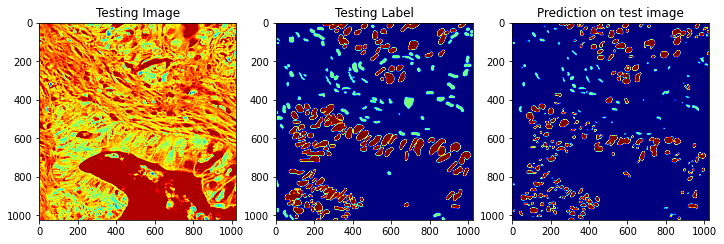

In [32]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='jet')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

In [52]:
X_test1[0].shape
# plt.imshow(X_test1[0])

(1024, 1024, 3)

1/1 [==============================] - 0s 30ms/step


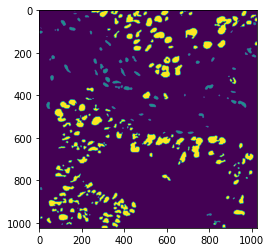

In [34]:
pred_dir_path = "/notebooks/pred_masks"
import random
test_img_number = random.randint(0, len(X_test1) - 1)
test_img = X_test1[test_img_number]

Y_pred = []
for i, test_img in enumerate(X_test1):
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    
    test_img_input1 = preprocess_input1(test_img_input)
    test_pred1 = model1.predict(test_img_input1)
    test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
    Y_pred.append(np.expand_dims(test_prediction1,2))
    # plt.imsave(f"{pred_dir_path}/img_{i}.png",test_pred
plt.imshow(Y_pred[0])
    

# Saving Validation Images 

In [77]:
val_images = sorted(glob.glob("/notebooks/validation_data/val_data/*.png"))
val_pred_dir_path = "/notebooks/validation_data/masks"

X_val = []
for val_img_path in val_images:
    X_val.append(cv2.imread(val_img_path,1))
X_val = preprocess_input1(X_val)

In [83]:
pred_val = []
for i, val_img in enumerate(X_val):
    val_img = np.expand_dims(val_img,0)
    val_img = preprocess_input1(val_img)
    pred_img = model1.predict(val_img)
    pred_img = np.argmax(pred_img, axis=3)[0,:,:]
    pred_val.append(np.expand_dims(pred_img,2))
    plt.imsave(f"{val_pred_dir_path}/{val_images[i].split('/')[-1]}",pred_img)

1/1 [==============================] - 0s 26ms/step
